In [35]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [19]:
# read input
df = pd.read_csv('opsd_austria_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.head(5)

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:15:00+00:00,2015-01-01T00:15:00+0100,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:30:00+00:00,2015-01-01T00:30:00+0100,NaN,NaN,NaN,NaN,NaN
2014-12-31 23:45:00+00:00,2015-01-01T00:45:00+0100,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN


In [20]:
df['Date'] = pd.to_datetime(df['cet_cest_timestamp'], utc=True)

In [21]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df.sample()

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,Date,Year,Month
utc_timestamp,,,,,,,,,
2019-10-10 05:15:00+00:00,2019-10-10T07:15:00+0200,8535.6,7892.0,NaN,24.0,660.0,2019-10-10 05:15:00+00:00,2019,10


In [22]:
# data imputation
def clean(dataset, columns):
    dataset[columns].replace(0, np.nan, inplace=True)
    dataset[columns].fillna(method='bfill', inplace=True) 
    dataset[columns].fillna(method='ffill', inplace=True)
# call a clean function here for Electricity_consumption, Wind_production columns

In [23]:
clean(df, 'AT_load_actual_entsoe_transparency')

In [24]:
clean(df, 'AT_wind_onshore_generation_actual')

In [25]:
# ensemble learning for regression
def ensemble_training(df_train, df_test, max_depth, n_estimators):
    label = 'AT_load_actual_entsoe_transparency'
    X_train = df_train.drop(label, axis=1)
    y_train = df_train.loc[:,label]
    X_test = df_test.drop(label, axis=1)
    y_test = df_test.loc[:,label]
    dtrab = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                              # check w hich value for max_depth gives better RMSE/MSE: 5, 10, 15, 20, 25
                              n_estimators=n_estimators,
                              # check which value for n_estimators gives better RMSE/MAE: 10, 20, 30, 40, 50, 100
                              random_state=1)
    dtrab.fit(X_train, y_train)
    y_predict=dtrab.predict(X_test)
    print('RMSE: %.6f' %(sqrt(mean_squared_error(y_test, y_predict))))
    print('MAE: %.6f' %(mean_absolute_error(y_test, y_predict)))
    df_sol=pd.DataFrame({'True': np.array(y_test),'Predicted': np.array(y_predict)})
    return dtrab, df_sol

In [26]:
features = ['AT_load_actual_entsoe_transparency','AT_wind_onshore_generation_actual','Month']
df_train = df.loc[df['Year']!=2019, features]
df_test = df.loc[df['Year']==2019, features]

In [14]:
def month_select(df, column):
    df_dummy = pd.get_dummies(df[column], prefix='M')
    df_new = pd.concat([df, df_dummy], axis=1)
    df_new = df_new.drop(column, axis=1)
    return df_new

In [27]:
df_train = month_select(df_train, 'Month')
df_test = month_select(df_test, 'Month')

**Проверим по отдельности, какие параметры для моделей лучше:**

In [47]:
X_train = df_train.drop('AT_load_actual_entsoe_transparency', axis=1)
y_train = df_train.loc[:,'AT_load_actual_entsoe_transparency']

In [58]:
parameters = {'max_depth': [5, 10, 15, 20, 25]}

model = DecisionTreeRegressor(random_state=1)
grid_search_tree = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error')
grid_search_tree.fit(X_train, y_train)
grid_search_tree.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [60]:
parameters = {'n_estimators':[10, 20, 30, 40, 50, 100]}

model = AdaBoostRegressor(random_state=1)
grid_search_ada = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error')
grid_search_ada.fit(X_train, y_train)
grid_search_ada.best_estimator_

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=20, random_state=1)

Для DecisionTreeRegressor лучший параметр для глубины составтяет 5, а для AdaBoostRegressor число деревьев - 20

Но посмотрим на значения MAE и RMSE, если мы будем их использовать в ансамбле:

In [31]:
df_sol = []
max_depth = [5, 10, 15, 20, 15]
n_estimators = [10, 20, 30, 40, 50, 100]
for md in max_depth:
    for ne in n_estimators:
        print('max_depth =', md, '   n_estimators=', ne)
        model, df_sol = ensemble_training(df_train, df_test, md, ne)
        df_sol = pd.concat([df_sol.reset_index(drop=True),
                  pd.Series(df.loc[df['Year']==2019,'Date']).reset_index(drop=True)], axis=1)
        print('__________________________', sep='\n')

max_depth = 5    n_estimators= 10
RMSE: 1300.721354
MAE: 1123.786042
____________
max_depth = 5    n_estimators= 20
RMSE: 1330.982745
MAE: 1142.575593
____________
max_depth = 5    n_estimators= 30
RMSE: 1330.982745
MAE: 1142.575593
____________
max_depth = 5    n_estimators= 40
RMSE: 1330.982745
MAE: 1142.575593
____________
max_depth = 5    n_estimators= 50
RMSE: 1330.982745
MAE: 1142.575593
____________
max_depth = 5    n_estimators= 100
RMSE: 1330.982745
MAE: 1142.575593
____________
max_depth = 10    n_estimators= 10
RMSE: 1322.226050
MAE: 1135.857492
____________
max_depth = 10    n_estimators= 20
RMSE: 1327.961717
MAE: 1139.221839
____________
max_depth = 10    n_estimators= 30
RMSE: 1332.218700
MAE: 1141.243652
____________
max_depth = 10    n_estimators= 40
RMSE: 1338.614553
MAE: 1144.790141
____________
max_depth = 10    n_estimators= 50
RMSE: 1341.189290
MAE: 1146.213639
____________
max_depth = 10    n_estimators= 100
RMSE: 1341.241034
MAE: 1146.383518
____________
max_dept

**Лучший результат:**

max_depth = 20   

n_estimators= 100


RMSE: 1299.097143


MAE: 1122.794141

In [32]:
df_sol = []

model, df_sol = ensemble_training(df_train, df_test, 20, 100)
df_sol = pd.concat([df_sol.reset_index(drop=True),
                  pd.Series(df.loc[df['Year']==2019,'Date']).reset_index(drop=True)], axis=1)

RMSE: 1299.097143
MAE: 1122.794141


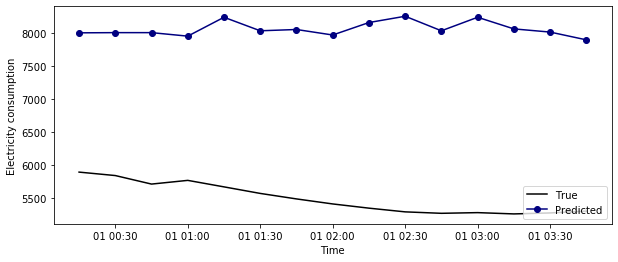

In [33]:
# visualization
fig,ax = plt.subplots(figsize=(10,4))
ax.plot_date(df_sol.loc[1:15,'Date'],
             df_sol.loc[1:15,'True'],
             marker='None',
             linestyle = '-',
             color='black', label='True')
ax.plot_date(df_sol.loc[1:15,'Date'],
             df_sol.loc[1:15,'Predicted'],
             marker='o',
             linestyle = '-',
             color='navy', markeredgecolor='navy', label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Electricity consumption')
ax.legend(loc='lower right')
plt.show()